In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils.Dataset import get_xray_dataloader
from utils.Transforms import ContrastAdjustment, Normalize
from utils.SCN import SCN
import time
import torch
from torch import optim
import math

In [2]:
num_landmarks = 130

In [3]:
dataloader = get_xray_dataloader(open(".\\datasources\\cross_validation_set.pt", "rb"), transforms=[ContrastAdjustment(), Normalize()], short=False, shorten_sets=True)

In [4]:
lr = 1e-6
momentum = 0.99
weight_decay = 0.0005
alpha = 20

In [5]:
def kaggle_method(x0, y0, sigma, height=512, width=512):
    x = np.arange(0, height, 1, float) ## (width,)
    y = np.arange(0, width, 1, float)[:, np.newaxis] ## (height,1)
    #print(x.dtype, y.dtype)
    #dist = ((x-x0)**2 + (y-y0)**2)
    dist = torch.from_numpy( ((x-x0)**2 + (y-y0)**2) )
    return torch.exp(-(dist/ (2*sigma**2)))

def heatmap_new_method(landmarks, sigmas):
    heatmaps = torch.zeros((landmarks.shape[0],512, 512), dtype=torch.float32)
    for lid, landmark in enumerate(landmarks):
        sigma = sigmas[lid].cpu()
        heatmaps[lid] = kaggle_method(landmark[0], landmark[1], sigma)
    
    #heatmaps /= heatmaps.max() 
    heatmaps = heatmaps.unsqueeze_(dim=0)
    return heatmaps

(130, 2)
0.6881725788116455 tensor(0.9997, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


<IPython.core.display.Javascript object>


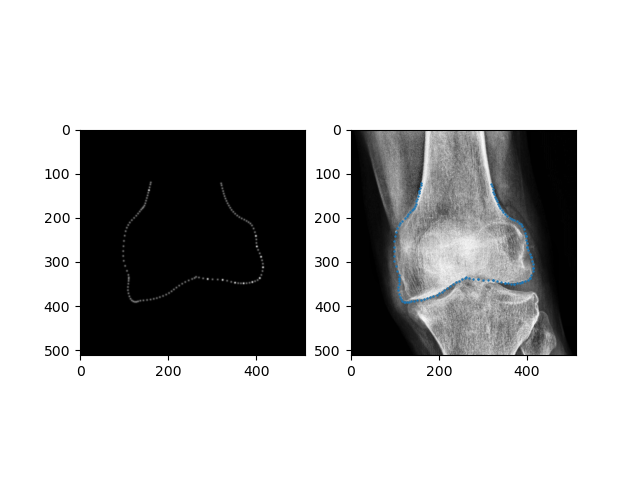

In [8]:
sigmas = torch.zeros((num_landmarks,1), dtype=torch.float32)
sigmas = sigmas.fill_(1.5)
sigmas.requires_grad=True
sigmas = torch.nn.Parameter(sigmas)
#sigmas.requires_grad = True
sample = next(iter(dataloader["trainloader"]))
image, landmarks = sample["image"], sample["landmarks"].squeeze_(dim=0).detach().numpy()

print(landmarks.shape)
prediction = torch.from_numpy(np.random.rand(landmarks.shape[0], 512, 512))
import time
start_time = time.time()
heatmaps = heatmap_new_method(landmarks, sigmas).squeeze_(dim=0)
end_time =  time.time()
print(str(end_time-start_time), heatmaps.max(), heatmaps.min())

loss = torch.nn.functional.mse_loss(prediction, heatmaps, reduction="sum")
loss.backward()

#print(np.allclose(heatmaps, heatmaps_new))

heatmap = np.zeros(heatmaps.shape[1:])
for hid, h in enumerate(heatmaps):
    heatmap += h.detach().numpy()

image = image.squeeze_(dim=0).cpu().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(heatmap, "gray")
#ax1.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.imshow(image, "gray")
ax2.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
plt.show()

In [6]:
scn = SCN(130)
use_cuda =  torch.cuda.is_available()

sigmas = torch.zeros(num_landmarks,1, dtype=torch.float32).fill_(1.5)
sigmas.requires_grad = True
sigmas = torch.nn.Parameter(sigmas)
if use_cuda:
    scn = scn.cuda()
optimizer = optim.SGD([
                {'params':scn.parameters(), 'weight_decay': weight_decay},
                {'params':sigmas, 'weight_decay':alpha}
            ], lr=lr, momentum=0.9, nesterov=True)
criterion = torch.nn.MSELoss(reduction="sum")

Initializing weights


In [7]:
import time
torch.autograd.set_detect_anomaly(True)
def train(n_epochs, loaders, heatmapgenerator, sigmas, model, optimizer, criterion, use_cuda=True, save_path=".\\weights\\model_130_dict.pt", load_weights=False, scheduler=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    
    if load_weights:
        model_dict = torch.load(save_path)
        model.load_state_dict(model_dict["model_state_dict"])
        optimizer.load_state_dict(model_dict["optimizer_state_dict"])
        valid_loss_min = model_dict["loss"]
        sigmas = model_dict["sigmas"]
        sigmas.requires_grad = True
        print("model, optimizer, sigmas and loss loaded")
        
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        start_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, sample in enumerate(loaders['trainloader']):
            optimizer.zero_grad()
            # move to GPU
            image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float), sample["landmarks"].squeeze_(dim=0).detach().numpy()
            #landmarks.requires_grad = False
            heatmaps = heatmapgenerator(landmarks, sigmas)
            
            if use_cuda:
                image, heatmaps = image.cuda(), heatmaps.cuda()
            prediction = model(image)
            loss = criterion(prediction, heatmaps)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 10 == 0:
                print('Epoch: {} \tTraining Loss: {:.6f} after {} batches'.format(epoch, train_loss, batch_idx))
                #if train_loss < train_loss_min :
                    #train_loss_min = train_loss
                    #model_dict = {'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(), 'loss':valid_loss_min, 'sigmas':sigmas}
                    #torch.save(model_dict, save_path)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, sample in enumerate(loaders['validloader']):
            # move to GPU
            image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float), sample["landmarks"].squeeze_(dim=0).detach().numpy()
            #landmarks.requires_grad = False
            heatmaps = heatmapgenerator(landmarks, sigmas)
            if use_cuda:
                image, heatmaps = image.cuda(), heatmaps.cuda()
            ## update the average validation loss
            with torch.no_grad():
                prediction = model(image)
                loss = criterion(prediction, heatmaps)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if scheduler is not None:
            scheduler.step(valid_loss) 
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min :
            valid_loss_min = valid_loss
            model_dict = {'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(), 'loss':valid_loss_min, 'sigmas':sigmas}
            torch.save(model_dict, save_path)
        end_time = time.time()
        print("Training Epoch  "+str(epoch)+" th finished in "+str(end_time-start_time))
    return model, optimizer, sigmas

In [8]:
num_iterations = 10
scn, optimizer, sigmas = train(num_iterations, dataloader, heatmap_new_method, sigmas, scn, optimizer, criterion, load_weights=True)

model, optimizer, sigmas and loss loaded
Epoch: 1 	Training Loss: 177.414276 after 0 batches
Epoch: 1 	Training Loss: 177.374771 after 10 batches
Epoch: 1 	Training Loss: 177.448257 after 20 batches
Epoch: 1 	Training Loss: 177.319748 after 30 batches
Epoch: 1 	Training Loss: 177.324448 after 40 batches
Epoch: 1 	Training Loss: 177.378464 after 50 batches
Epoch: 1 	Training Loss: 177.393707 after 60 batches
Epoch: 1 	Training Loss: 177.342056 after 70 batches


KeyboardInterrupt: 

In [11]:
def get_coordinates(heatmaps, landmarks):
    print(heatmaps.shape)
    coords = np.zeros((heatmaps.shape[0], 2), dtype=np.float32)
    for hid, heatmap in enumerate(heatmaps):
        max_index = np.argmax(heatmap)
        coords[hid] = np.flip(np.array(np.unravel_index(max_index, heatmap.shape), np.int32), axis=0)
        #print(landmarks[hid], coords[hid])
    return coords

tensor(12.8274, device='cuda:0')
(33, 512, 512)
[393.08685 118.89766] [394. 127.]
[399.98447 147.78911] [400. 149.]
[413.12918 168.3217 ] [402. 154.]
[421.06332 179.97948] [230. 465.]
[430.1605  199.04944] [424. 191.]
[443.54572 226.49522] [470. 431.]
[444.2302 249.3352] [381. 496.]
[439.0985 277.1208] [477. 453.]
[435.89124 289.05853] [479. 435.]
[434.56265 304.78378] [430. 298.]
[422.0809 318.6717] [409. 321.]
[408.3324  322.08398] [395. 322.]
[381.05658 321.87122] [378. 321.]
[362.751  319.4013] [368. 320.]
[349.30783 313.43933] [366. 319.]
[326.65012 297.86673] [322. 293.]
[309.4914  290.30057] [299. 291.]
[278.314   300.20828] [277. 300.]
[246.70926 320.99756] [264. 311.]
[218.57977 325.87173] [222. 325.]
[184.89014 323.99127] [214. 325.]
[173.87224 306.2337 ] [184. 322.]
[172.91508 284.86963] [173. 341.]
[170.95723 271.7905 ] [169. 268.]
[164.35144 260.732  ] [169. 266.]
[157.81174 246.0385 ] [159. 199.]
[154.97412 224.44974] [172. 274.]
[157.06927 208.24081] [162. 190.]
[162.335

<IPython.core.display.Javascript object>


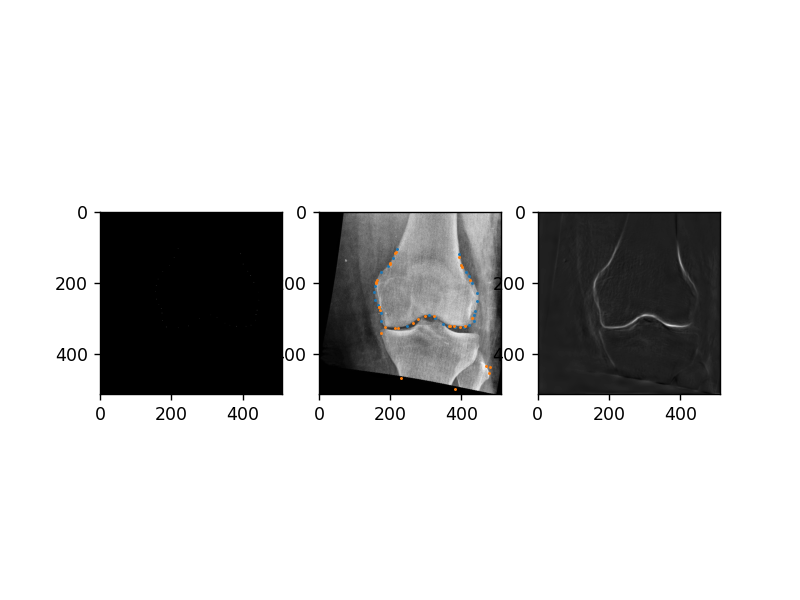

In [16]:
#model_dict = torch.load(".\\weights\\model_130_dict.pt")
#scn.load_state_dict(model_dict["model_state_dict"])
#sigmas = model_dict["sigmas"]
#print(model_dict['loss'])
#print(sigmas)
sample = next(iter(dataloader["testloader"]))
scn.eval()
image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float32), sample["landmarks"].squeeze_(dim=0).detach().numpy()
#landmarks.requires_grad = False
heatmaps = heatmap_new_method(landmarks, sigmas)
if use_cuda:
    image, heatmaps = image.cuda(), heatmaps.cuda()
with torch.no_grad():
    prediction = scn(image)
    diff = (prediction - heatmaps)
    loss = criterion(prediction, heatmaps)
    print(loss.data)

heatmaps = heatmaps.cpu().squeeze_(dim=0)
heatmap = torch.zeros(heatmaps.shape[1:])
for h in heatmaps:
    heatmap += h
predictions = torch.zeros(heatmaps.shape[1:])

prediction = prediction.cpu().squeeze_(dim=0)
for p in prediction:
    predictions+= p

heatmap = heatmap.detach().numpy()
predictions = predictions.detach().numpy()
image = image.squeeze_(dim=0).squeeze_(dim=0).cpu().numpy()
predicted_lands = get_coordinates(prediction, landmarks)
#landmarks = landmarks.cpu()
#print(landmarks, predicted_lands)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(heatmap, "gray")
#ax1.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.imshow(image, "gray")
ax2.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.scatter(predicted_lands[:,0], predicted_lands[:,1], s=0.5)
ax3.imshow(predictions, "gray")
plt.show()